In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, pickle
from pyuvdata import UVData
import numpy as np
import uvtools
import scipy.signal
from astropy import units
from hera_cal.frf import load_tophat_frfilter_and_write

plt.rcParams["xtick.labelbottom"] = True
plt.rcParams["xtick.labeltop"] = False

In [2]:
def fringe_rates(uu):
    times = np.unique(uu.time_array)
    fr = uvtools.utils.fourier_freqs(times * units.day.to("s"))
    fr *= units.Hz.to("mHz")
    
    return fr

# Keep track of what state an array is in, fft/data shifted or not, windowed (not working).
class data_and_state:
    def __init__(self, a, state="data", shifted=False, window=None):   
        self.a = a
        self.state = state
        self.shifted = shifted   # If True then fftshift has been run
        self.window = window
        
def do_fft(das, window=None):
    assert das.state == "data" and das.window is None
    if window is None:
        w = np.ones(das.a.size)
    else:
        w = scipy.signal.blackmanharris(das.a.size)
    new_das = data_and_state(np.fft.fft(das.a*w)/das.a.size, "fft", shifted=False, window=window)
    
    return new_das
    
def do_ifft(das):
    assert das.state == "fft"
    assert not das.shifted
    assert das.window is None or das.window == "blackmanharris"
    return data_and_state(np.fft.ifft(das.a)*das.a.size, state="data", shifted=False, window=None)
    
def dc_at_0(das):
    assert das.state == "fft"
    if das.shifted:
        new_das = data_and_state(np.fft.ifftshift(das.a), state="fft", shifted=False)
    else:
        new_das = copy.copy(das)
    return new_das
        
def dc_at_centre(das):
    assert das.state == "fft"
    if das.shifted:
        new_das = copy.copy(das)
    else:
        new_das = data_and_state(np.fft.fftshift(das.a), state="fft", shifted=True)
        
    return new_das

def shift_data(das):
    assert das.state == "data"
    if das.shifted:
        new_das = copy.copy(das)
    else:
        new_das = data_and_state(np.fft.fftshift(das.a), state="data", shifted=True)
        
    return new_das

def unshift_data(das):
    assert das.state == "data"
    if das.shifted:
        new_das = data_and_state(np.fft.ifftshift(das.a), state="data", shifted=False)
    else:
        new_das = copy.copy(das)
    return new_das

def multiply_fft(fft1, fft2):
    assert fft1.state == "fft"
    assert fft1.window is None or fft1.window == "blackmanharris"
    assert fft2.state == "fft"
    assert fft2.window is None or fft2.window == "blackmanharris"
    assert fft1.shifted == fft2.shifted
    assert fft1.window == fft2.window
    
    return data_and_state(fft1.a*fft2.a, state="fft", shifted=fft1.shifted, window=fft1.window)

def divide_fft(fft1, fft2):
    assert fft1.state == "fft"
    assert fft1.window is None or fft1.window == "blackmanharris"
    assert fft2.state == "fft"
    assert fft2.window is None or fft2.window == "blackmanharris"
    assert fft1.shifted == fft2.shifted
    assert fft1.window == fft2.window
    
    return data_and_state(fft1.a/fft2.a, state="fft", shifted=fft1.shifted, window=fft1.window)

def conj(das):
    assert das.state == "fft"
    return data_and_state(np.conj(das.a), state=das.state, shifted=das.shifted, window=das.window)
   
def convolve(das1, das2, method="direct"):
    assert method in [ "direct", "fft" ]
    assert das1.state == "data" and das2.state == "data"
    assert das1.shifted == False and das2.shifted == False
    assert das1. window is None and das2.window is None

    if method == "direct":
        return data_and_state(scipy.signal.convolve(das1.a, das2.a, method="direct", mode="same"))
    
    else:
        das2_s = shift_data(das2)
        fft1 = do_fft(das1)
        fft2 = do_fft(das2_s)
        convolve_fft = fft1.a*fft2.a
        return scipy.signal.convolve(das1.a, das2.a, method="fft", mode="same")
        return np.fft.ifft(convolve_fft)  
    
    
def print_das(das):
    print(das.a)
    print(das.state, das.shifted, das.window)
    
# Filter an array using a tophat or notch by masking out certain modes.
def diy_filter(fin, bl, frf_centre, frf_half_width, case, window):
    print("DIY Filter")
    uvd = UVData()
    uvd.read_uvh5(fin)
    frates = fringe_rates(uvd)
    left = np.where(frates>frf_centre-frf_half_width)[0][0]
    right =  np.where(frates>frf_centre+frf_half_width)[0][0]

    bl_data = uvd.get_data(bl, "XX")[:, 0]

    # Create mask
    mask = np.ones(bl_data.size)
    mask[:left] = 0
    mask[right:] = 0

    if case == "notch":
        mask = np.where(mask==1, 0, 1)
    mask = data_and_state(mask, state="fft", shifted=True)
    
    data = data_and_state(bl_data)
    fft = do_fft(data, window=window)
    fft = dc_at_centre(fft)
    
    after_fft = multiply_fft(fft, mask)
    after_data = do_ifft(dc_at_0(after_fft))
    
    print("Modes before filter", fft.a.size)
    print("Modes after filter", after_fft.a[np.abs(after_fft.a)!=0].size)
    if case == "mainlobe":
        print("Modes left", frates[np.abs(after_fft.a)!=0])
    else:
        print("Modes removed", frates[np.abs(after_fft.a)==0])
    print("Actual filter half width", (frates[right]-frates[left])/2)
    
    return after_data.a

def frf_avg_length(f):
    def min_frf_width(fname):
        with open("frf_ranges_mainlobe.pkl", "rb") as f:
            frf_ranges = pickle.load(f)
            return np.min(np.abs(list(frf_ranges["frate_half_widths"].values())))
        
    print((min_frf_width(f)))
    # We need the maximum 1/f time based on all the filters
    return 1/(min_frf_width(f)*1e-3)    # frf width in Hz, and invert it, gives width of sinc main lobe

# Run a filter and plot filtered and unfilterd. try_get_kernel means find the kernel i nreal space by dividing FFTs
# (only really works for the diy_filter.)
def plot_baseline(uvd, bl, case="mainlobe", frf_mode="dpss_leastsq", window=None, try_get_kernel=False, try_get_kernel_threshold=1):
    # bls = [ (0, 2), (3, 6), (7, 11), (12, 17)]
    
    assert case in [ "mainlobe", "notch" ], "Unknown filter"
    assert frf_mode in [ "clean", "dpss_leastsq", "diy"], "Unknown filter mode"
    
    if case == "mainlobe":
        with open("frf_ranges_mainlobe.pkl", "rb") as f:
            frf_ranges = pickle.load(f)

            frf_centre = frf_ranges["frate_centers"][(bl[0], bl[1], "ee")]
            frf_half_width = frf_ranges["frate_half_widths"][(bl[0], bl[1], "ee")]
    else:
        frf_centre = 0
        frf_half_width = 0.025

    print("filter centre", frf_centre, "filter half width", frf_half_width)

    if try_get_kernel:
        n_subplots = 4
        plt.figure(figsize=(12, 12))
    else:
        n_subplots = 2
        plt.figure(figsize=(12, 6))
    

    lsts = np.unique(uvd.lst_array)*12/np.pi
    frates = fringe_rates(uvd)
    bl_data = uvd.get_data(bl, "XX")[:, 0]
    
    plt.subplot(n_subplots, 2, 1)
    plt.plot(lsts, bl_data.real, label="Real value")
    plt.plot(lsts, np.abs(bl_data), "r", label="Amplitude")
    plt.legend()
    plt.xlabel("LST")
    plt.title("Fringes from baseline "+str(bl))
    
    cut = 80
    plt.subplot(n_subplots, 2, 2)
    before_fft = do_fft(data_and_state(bl_data, state="data", shifted=False), window=window)
    before_fft = dc_at_centre(before_fft)
    plt.plot(frates[bl_data.size//2-cut:bl_data.size//2+cut], np.abs(before_fft.a)[bl_data.size//2-cut:bl_data.size//2+cut], "g", label="Amplitude")
    plt.axvline(frf_centre-frf_half_width, color="k", lw=0.5)
    plt.axvline(frf_centre+frf_half_width, color="k", lw=0.5)
    plt.legend()
    plt.xlabel("Fringe rate")
    plt.title("Fringe rates from baseline "+str(bl))
    
    uvd1 = uvd.select(bls=[bl], inplace=False)
    uvd1.write_uvh5("/tmp/frftmp.uvh5", clobber=True)
    
    beam = "/lustre/aoc/projects/hera/H4C/beams/NF_HERA_Vivaldi_efield_beam_healpix.fits"
    
    if frf_mode == "diy":
        bl_data = diy_filter("/tmp/frftmp.uvh5", bl, frf_centre, frf_half_width, case, window)
    elif case == "mainlobe":
        load_tophat_frfilter_and_write(["/tmp/frftmp.uvh5"], case="uvbeam", 
                            CLEAN_outfilename = "/tmp/frftmp_out.uvh5",
                            beamfitsfile=beam,
                            percentile_low=5, percentile_high=95,  clobber=True, frate_standoff=0.05, 
                            min_frate_half_width=0.15, skip_autos=True, verbose=True, 
                            mode=frf_mode)
        os.remove("/tmp/frftmp.uvh5")
    
        uvd1.read_uvh5("/tmp/frftmp_out.uvh5")


        bl_data = uvd1.get_data(bl, "XX")[:, 0]
    elif case == "notch":
        load_tophat_frfilter_and_write(["/tmp/frftmp.uvh5"], case="max_frate_coeffs", 
                         res_outfilename = "/tmp/frftmp_out.uvh5",  
                         clobber=True, max_frate_coeffs=[frf_centre, frf_half_width], skip_autos=True, 
                                       verbose=True, mode=frf_mode)

        os.remove("/tmp/frftmp.uvh5")
    
        uvd1.read_uvh5("/tmp/frftmp_out.uvh5")


        bl_data = uvd1.get_data(bl, "XX")[:, 0]

    plt.subplot(n_subplots, 2, 3)
    plt.plot(lsts, bl_data.real, label="Real value")
    plt.plot(lsts, np.abs(bl_data), "r", label="Amplitude")
    plt.legend()
    plt.xlabel("LST")
    plt.title("Filtered fringes from baseline "+str(bl))
    
    cut = 80
    plt.subplot(n_subplots, 2, 4)
    after_fft = do_fft(data_and_state(bl_data, state="data", shifted=False), window=window)
    after_fft = dc_at_centre(after_fft)
    plt.plot(frates[bl_data.size//2-cut:bl_data.size//2+cut], np.abs(after_fft.a)[bl_data.size//2-cut:bl_data.size//2+cut], "g", label="Amplitude")
    plt.axvline(frf_centre-frf_half_width, color="k", lw=0.5)
    plt.axvline(frf_centre+frf_half_width, color="k", lw=0.5)
    plt.legend()
    plt.xlabel("Fringe rate")
    plt.title("Filtered fringe rates from baseline "+str(bl))

    if try_get_kernel:
        assert np.min(np.abs(before_fft.a)) > 0, "Zeros in FFT, can't divide"
        
        if case != "diy":
            low_values = np.logical_or(np.abs(before_fft.a)<try_get_kernel_threshold, np.abs(after_fft.a)<try_get_kernel_threshold)
            after_fft.a[low_values] = 0

        kernel_fft = divide_fft(after_fft, before_fft)
        recover = multiply_fft(before_fft, kernel_fft)
        print("Recovery error", np.abs(np.min(recover.a-after_fft.a)))


        kernel = do_ifft(dc_at_0(kernel_fft))
        kernel = shift_data(kernel)
        plt.subplot(4, 2, 5)
        plt.plot(lsts, np.abs(kernel.a), "r", label="Amplitude")
        plt.legend()
        plt.xlabel("LST")
        plt.title("Fringe-rate convolution kernel for "+str(bl))

        plt.subplot(n_subplots, 2, 6)
        plt.plot(frates[bl_data.size//2-cut:bl_data.size//2+cut], np.abs(kernel_fft.a)[bl_data.size//2-cut:bl_data.size//2+cut], "g", label="Amplitude")
        plt.axvline(frf_centre-frf_half_width, color="k", lw=0.5)
        plt.axvline(frf_centre+frf_half_width, color="k", lw=0.5)
        plt.legend()
        plt.xlabel("Fringe rate")
        plt.title("Kernel fringe rates from baseline "+str(bl))

        convolved = scipy.signal.convolve(uvd.get_data(bl, "XX")[:, 0], kernel.a, method="direct", mode="same")
        convolved_fft = dc_at_centre(do_fft(data_and_state(convolved), window=window))

        plt.subplot(n_subplots, 2, 7)
        plt.plot(lsts, convolved.real, label="Real value")    
        plt.plot(lsts, np.abs(convolved), "r", label="Amplitude")    
        plt.legend()
        plt.xlabel("LST")
        plt.title("Data convolved with kernel "+str(bl))

        plt.subplot(4, 2, 8)
        plt.plot(frates[bl_data.size//2-cut:bl_data.size//2+cut], np.abs(convolved_fft.a)[bl_data.size//2-cut:bl_data.size//2+cut], "g", label="Amplitude")
        plt.axvline(frf_centre-frf_half_width, color="k", lw=0.5)
        plt.axvline(frf_centre+frf_half_width, color="k", lw=0.5)
        plt.legend()
        plt.xlabel("Fringe rate")
        plt.title("FFT of data convolved with kernel "+str(bl))

        if os.path.exists("/tmp/frftmp_out.uvh5"): os.remove("/tmp/frftmp_out.uvh5")

        output = "kernel_"+case
        np.save(output, shift_data(kernel).a)
        print("save", output)
        output = "kernel_fft_"+case
        np.save(output, dc_at_centre(kernel_fft).a)
        print("save", output)
    
    plt.suptitle("Operation of "+frf_mode+" on fringes")
    plt.tight_layout()
    
    return before_fft.a, after_fft.a
  


In [3]:
#input_file = "data_unfiltered_lores.uvh5"; bl = (53, 85)
input_file = "viscatBC_one_source.uvh5"; bl = (7, 11)

uvd = UVData()

uvd.read_uvh5(input_file, bls=[bl])

Telescope hera_sim is not in known_telescopes.


In [4]:

frates = fringe_rates(uvd)
window = None #"blackmanharris"

# True tophat

Show the action of the filter. This filter simply masks out undesired fringe-rates by doing an FFT, masking, and doing a inverse FFT. Called "diy" (do-it-youself). Does not use HERA code.

(7, 11)
filter centre -1.3098151000561469 filter half width 0.2865795494620769


Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Fixing auto polarization power beams to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 5.075482475673413e-13.
UVBeam object already in healpix format...


Generating FR-Profile of (7, 11, 'nn') at 2023-06-05 13:18:04.036137
Generating FR-Profile of (7, 11, 'ee') at 2023-06-05 13:18:04.945690
Starting fourier filter of (11, 7, 'ee') at 2023-06-05 13:18:05.809428
Starting fourier filter of (11, 7, 'nn') at 2023-06-05 13:18:12.369202
...writing to /tmp/frftmp_out.uvh5


Telescope hera_sim is not in known_telescopes.


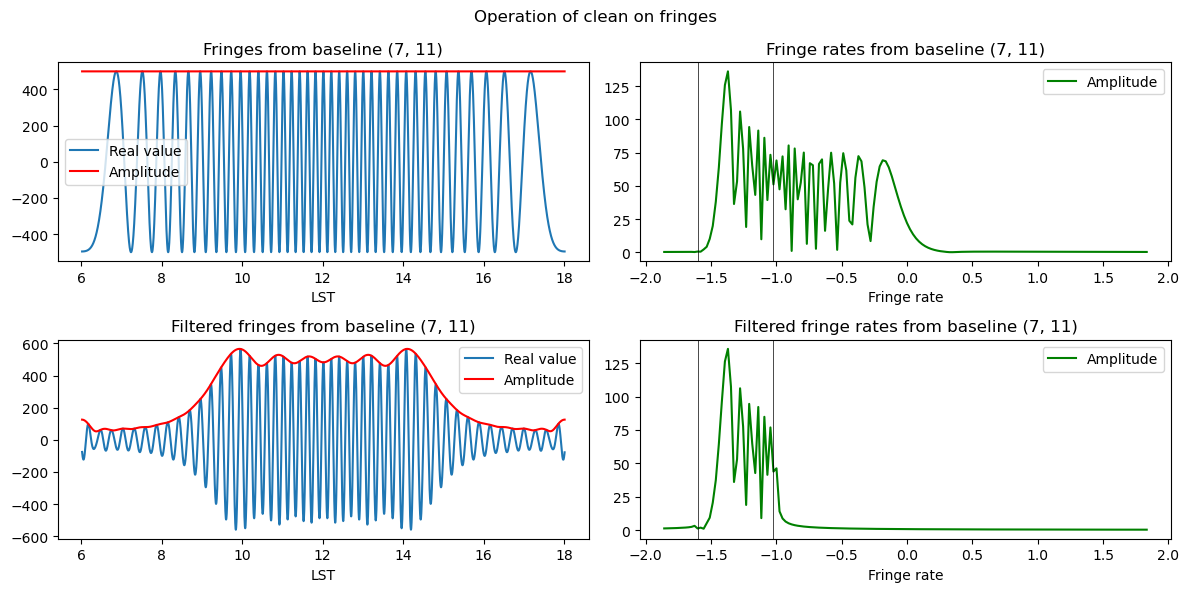

In [5]:
print(bl)
before_tophat_fft, after_tophat_fft = plot_baseline(uvd, bl, case="mainlobe", frf_mode="clean", window=window)

### Show the difference between before/after filter

In [ ]:
cut = 70                           # Zoom in where the action is
plt.figure(figsize=(12, 8))

fr = frates[frates.size//2-cut:frates.size//2+cut]

plt.subplot(3, 1, 1)
plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(before_tophat_fft)[frates.size//2-cut:frates.size//2+cut], label="Fringe rates before filtering", lw=1)
plt.axvline(0.025, color="k", lw=0.2)
plt.axvline(-0.025, color="k", lw=0.2)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(after_tophat_fft)[frates.size//2-cut:frates.size//2+cut], label="tophat", lw=0.5)
plt.legend()

plt.subplot(3, 1, 2)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(before_tophat_fft-after_tophat_fft)[frates.size//2-cut:frates.size//2+cut], label="before-tophat", lw=0.5)
plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(after_tophat_fft)[frates.size//2-cut:frates.size//2+cut], label="Fringe rates after CLEAN filtering", lw=1)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(before_tophat_fft-after_dpss_fft)[frates.size//2-cut:frates.size//2+cut], label="before-dpss", lw=0.5)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(before_tophat_fft-after_dpss_skip_fft)[frates.size//2-cut:frates.size//2+cut], label="before-dpss_skip", lw=0.5)
plt.legend()
plt.axvline(-0.025, color="k", lw=0.2)
plt.axvline(0.025, color="k", lw=0.2)


plt.subplot(3, 1, 3)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(after_tophat_fft)[frates.size//2-cut:frates.size//2+cut], label="before-clean", lw=0.5)
plt.plot(frates[frates.size//2-cut:frates.size//2+cut], (np.abs(after_tophat_fft)-np.abs(before_tophat_fft))[frates.size//2-cut:frates.size//2+cut], "r", label="Notch produced by CLEAN", lw=1)
plt.axvline(-0.025, color="k", lw=0.2)
plt.axvline(0.025, color="k", lw=0.2)
plt.xlabel("Fringe rates [mHz]")
plt.legend()

plt.suptitle("Tophat. Subtracting before/after filtering")
plt.tight_layout()
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(clean_fft)[frates.size//2-cut:frates.size//2+cut], label="clean", lw=0.5)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(dpss_fft)[frates.size//2-cut:frates.size//2+cut], label="dpss", lw=0.5)
#plt.legend()

# CLEAN

Show the action of the filter.

filter centre 0 filter half width 0.025
File exists; clobbering


Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


Starting fourier filter of (11, 7, 'ee') at 2023-05-11 10:14:45.702314
Starting fourier filter of (11, 7, 'nn') at 2023-05-11 10:14:46.644163
File exists; clobbering
...writing to /tmp/frftmp_out.uvh5


Telescope hera_sim is not in known_telescopes.


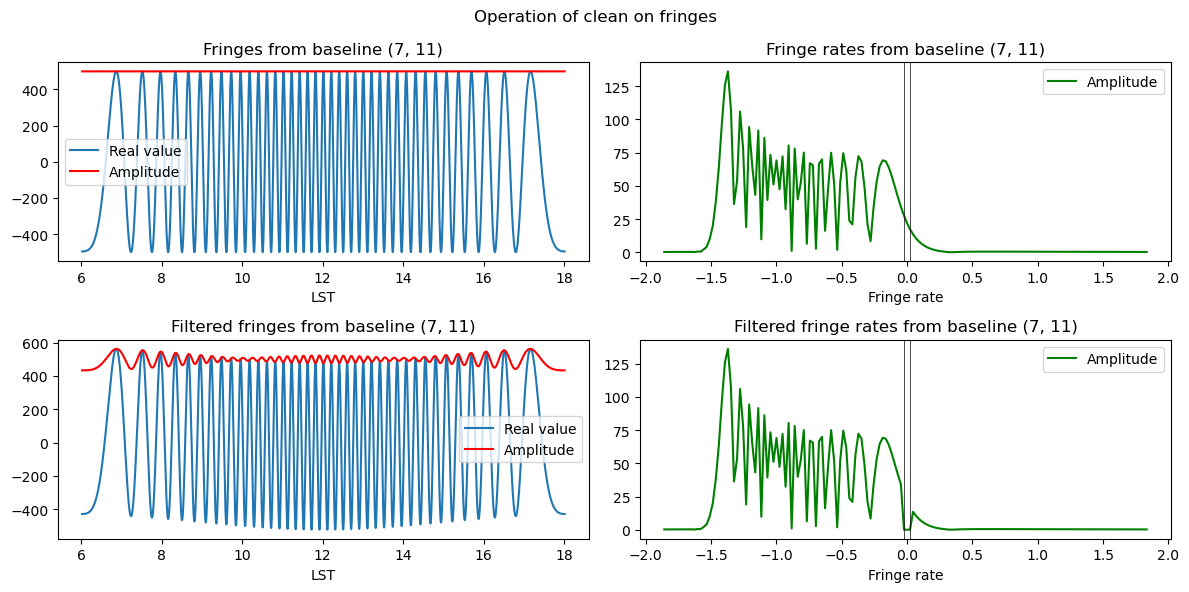

In [114]:
before_clean_fft, after_clean_fft = plot_baseline(uvd, bl, case="notch", frf_mode="clean", window=window)

### Show the difference between before/after filter

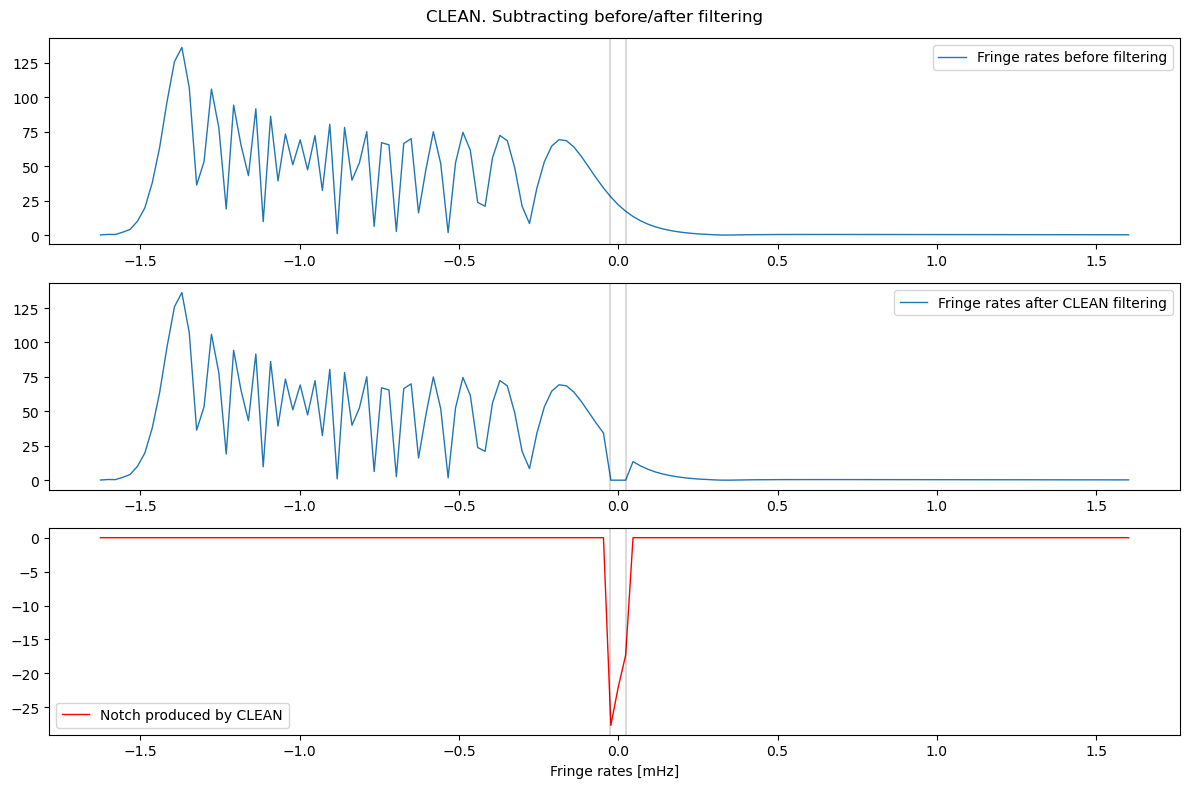

In [115]:
cut = 70                           # Zoom in where the action is
plt.figure(figsize=(12, 8))

fr = frates[frates.size//2-cut:frates.size//2+cut]

plt.subplot(3, 1, 1)
plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(before_clean_fft)[frates.size//2-cut:frates.size//2+cut], label="Fringe rates before filtering", lw=1)
plt.axvline(0.025, color="k", lw=0.2)
plt.axvline(-0.025, color="k", lw=0.2)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(after_tophat_fft)[frates.size//2-cut:frates.size//2+cut], label="tophat", lw=0.5)
plt.legend()

plt.subplot(3, 1, 2)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(before_tophat_fft-after_tophat_fft)[frates.size//2-cut:frates.size//2+cut], label="before-tophat", lw=0.5)
plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(after_clean_fft)[frates.size//2-cut:frates.size//2+cut], label="Fringe rates after CLEAN filtering", lw=1)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(before_tophat_fft-after_dpss_fft)[frates.size//2-cut:frates.size//2+cut], label="before-dpss", lw=0.5)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(before_tophat_fft-after_dpss_skip_fft)[frates.size//2-cut:frates.size//2+cut], label="before-dpss_skip", lw=0.5)
plt.legend()
plt.axvline(-0.025, color="k", lw=0.2)
plt.axvline(0.025, color="k", lw=0.2)


plt.subplot(3, 1, 3)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(after_tophat_fft)[frates.size//2-cut:frates.size//2+cut], label="before-clean", lw=0.5)
plt.plot(frates[frates.size//2-cut:frates.size//2+cut], (np.abs(after_clean_fft)-np.abs(before_clean_fft))[frates.size//2-cut:frates.size//2+cut], "r", label="Notch produced by CLEAN", lw=1)
plt.axvline(-0.025, color="k", lw=0.2)
plt.axvline(0.025, color="k", lw=0.2)
plt.xlabel("Fringe rates [mHz]")
plt.legend()

plt.suptitle("CLEAN. Subtracting before/after filtering")
plt.tight_layout()
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(clean_fft)[frates.size//2-cut:frates.size//2+cut], label="clean", lw=0.5)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(dpss_fft)[frates.size//2-cut:frates.size//2+cut], label="dpss", lw=0.5)
#plt.legend()

# DPSS (leastsq)

Show the action of the filter.

filter centre 0 filter half width 0.025


Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


Starting fourier filter of (11, 7, 'ee') at 2023-05-11 10:14:51.106132
Starting fourier filter of (11, 7, 'nn') at 2023-05-11 10:14:51.990371
File exists; clobbering
...writing to /tmp/frftmp_out.uvh5


Telescope hera_sim is not in known_telescopes.


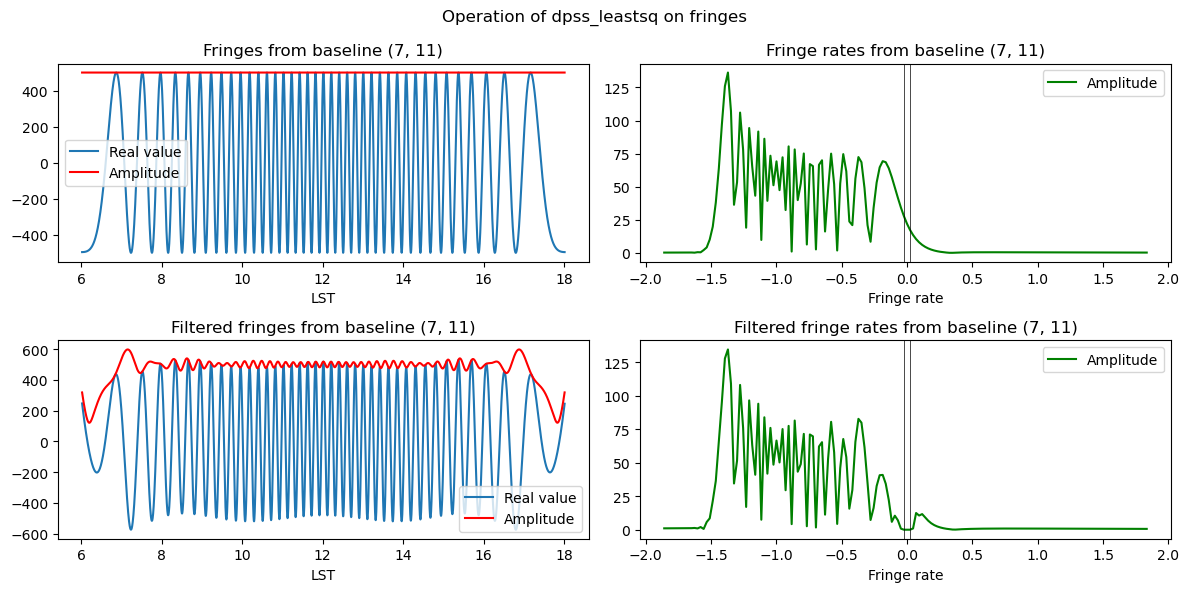

In [116]:
before_dpss_fft, after_dpss_fft = plot_baseline(uvd, bl, case="notch", frf_mode="dpss_leastsq", window=window)

### Show the difference between before/after filter

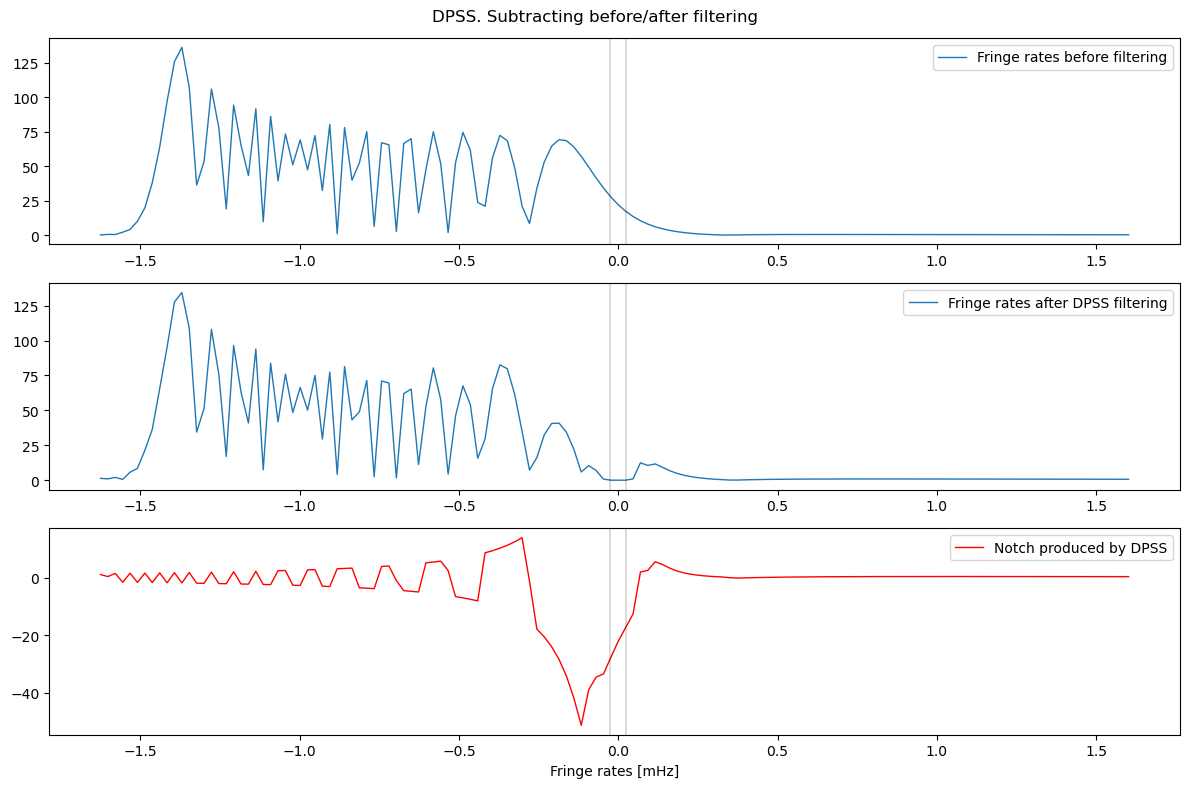

In [117]:
cut = 70
plt.figure(figsize=(12, 8))

fr = frates[frates.size//2-cut:frates.size//2+cut]
plt.subplot(3, 1, 1)
plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(before_dpss_fft)[frates.size//2-cut:frates.size//2+cut], label="Fringe rates before filtering", lw=1)
plt.axvline(0.025, color="k", lw=0.2)
plt.axvline(-0.025, color="k", lw=0.2)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(after_tophat_fft)[frates.size//2-cut:frates.size//2+cut], label="tophat", lw=0.5)
plt.legend()

plt.subplot(3, 1, 2)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(before_tophat_fft-after_tophat_fft)[frates.size//2-cut:frates.size//2+cut], label="before-tophat", lw=0.5)
plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(after_dpss_fft)[frates.size//2-cut:frates.size//2+cut], label="Fringe rates after DPSS filtering", lw=1)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(before_tophat_fft-after_dpss_fft)[frates.size//2-cut:frates.size//2+cut], label="before-dpss", lw=0.5)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(before_tophat_fft-after_dpss_skip_fft)[frates.size//2-cut:frates.size//2+cut], label="before-dpss_skip", lw=0.5)
plt.legend()
plt.axvline(-0.025, color="k", lw=0.2)
plt.axvline(0.025, color="k", lw=0.2)


plt.subplot(3, 1, 3)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(after_tophat_fft)[frates.size//2-cut:frates.size//2+cut], label="before-clean", lw=0.5)
plt.plot(frates[frates.size//2-cut:frates.size//2+cut], (np.abs(after_dpss_fft)-np.abs(before_dpss_fft))[frates.size//2-cut:frates.size//2+cut], "r", label="Notch produced by DPSS", lw=1)
plt.axvline(-0.025, color="k", lw=0.2)
plt.axvline(0.025, color="k", lw=0.2)
plt.xlabel("Fringe rates [mHz]")
plt.legend()

plt.suptitle("DPSS. Subtracting before/after filtering")
plt.tight_layout()
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(clean_fft)[frates.size//2-cut:frates.size//2+cut], label="clean", lw=0.5)
#plt.plot(frates[frates.size//2-cut:frates.size//2+cut], np.abs(dpss_fft)[frates.size//2-cut:frates.size//2+cut], label="dpss", lw=0.5)
#plt.legend()